# Описание проекта

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. 

### Задачи проекта

Обучить модель для определения рыночной стоимости автомобиля.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

### Описание данных

Данные находятся в файле `/datasets/autos.csv`

Признаки:
* `DateCrawled` — дата скачивания анкеты из базы
* `VehicleType` — тип автомобильного кузова
* `RegistrationYear` — год регистрации автомобиля
* `Gearbox` — тип коробки передач
* `Power` — мощность (л. с.)
* `Model` — модель автомобиля
* `Kilometer` — пробег (км)
* `RegistrationMonth` — месяц регистрации автомобиля
* `FuelType` — тип топлива
* `Brand` — марка автомобиля
* `NotRepaired` — была машина в ремонте или нет
* `DateCreated` — дата создания анкеты
* `NumberOfPictures` — количество фотографий автомобиля
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)
* `LastSeen` — дата последней активности пользователя

Целевой признак
* `Price` — цена (евро)

# Содержание <a name="title"></a>

[Импорт библиотек и задание констант](#import)
1. [Загрузка и подготовка данных](#1)

    1.1 [Обработка дубликатов](#1.1)
    
    1.2 [Обработка пропусков и удаление аномалий](#1.2)
    
 
2. [Обоснование алгоритма преобразования](#2)

    2.1 [Обучение CatBoost](#2.1)
    
    2.2 [Обучение LightGBM](#2.2)

    2.3 [Обучение логистической регрессии](#2.3)
    
    
3. [Анализ моделей](#3)

# Импорт библиотек и задание констант <a name="import"></a>

In [1]:
import pandas as pd
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

from catboost import Pool, cv
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import warnings


RNG = 42

In [2]:
class Explorer:
    class show(object):
        template = """<div style="float: left; padding: 10px;">
        <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
        </div>"""

        def __init__(self, *args):
            self.args = args
    
        def _repr_html_(self):
            return '\n'.join(self.template.format(a, eval(a)._repr_html_()) for a in self.args)
        
    def hexbin(self, data, x, y):
        data.plot(x = x, y = y, kind='hexbin', gridsize=20, figsize=(15, 10), sharex=False, grid=True)        

explorer = Explorer()

def review(data, i):
    return pd.concat([data.head(i), data.tail(i)], keys=['head', 'tail'])

[Содержание](#title)

# 1. Загрузка и подготовка данных <a name="1"></a>

In [3]:
df = pd.read_csv("/datasets/autos.csv")

Посмотрим на данные

In [4]:
review(df, 4)

DateCrawled  Price  VehicleType  RegistrationYear  \
head 0       2016-03-24 11:52:17    480          NaN              1993   
     1       2016-03-24 10:58:45  18300        coupe              2011   
     2       2016-03-14 12:52:21   9800          suv              2004   
     3       2016-03-17 16:54:04   1500        small              2001   
tail 354365  2016-03-14 17:48:27   2200          NaN              2005   
     354366  2016-03-05 19:56:21   1199  convertible              2000   
     354367  2016-03-19 18:57:12   9200          bus              1996   
     354368  2016-03-20 19:41:08   3400        wagon              2002   

            Gearbox  Power        Model  Kilometer  RegistrationMonth  \
head 0       manual      0         golf     150000                  0   
     1       manual    190          NaN     125000                  5   
     2         auto    163        grand     125000                  8   
     3       manual     75         golf     150000                  6   
tail 354365     NaN      0          NaN      20000                  1   
     354366    auto    101       fortwo     125000                  3   
     354367  manual    102  transporter     150000                  3   
     354368  manual    100         golf     150000                  6   

             FuelType           Brand NotRepaired          DateCreated  \
head 0         petrol      volkswagen         NaN  2016-03-24 00:00:00   
     1       gasoline            audi         yes  2016-03-24 00:00:00   
     2       gasoline            jeep         NaN  2016-03-14 00:00:00   
     3         petrol      volkswagen          no  2016-03-17 00:00:00   
tail 354365       NaN  sonstige_autos         NaN  2016-03-14 00:00:00   
     354366    petrol           smart          no  2016-03-05 00:00:00   
     354367  gasoline      volkswagen          no  2016-03-19 00:00:00   
     354368  gasoline      volkswagen         NaN  2016-03-20 00:00:00   

             NumberOfPictures  PostalCode             LastSeen  
head 0                      0       70435  2016-04-07 03:16:57  
     1                      0       66954  2016-04-07 01:46:50  
     2                      0       90480  2016-04-05 12:47:46  
     3                      0       91074  2016-03-17 17:40:17  
tail 354365                 0       39576  2016-04-06 00:46:52  
     354366                 0       26135  2016-03-11 18:17:12  
     354367                 0       87439  2016-04-07 07:15:26  
     354368                 0       40764  2016-03-24 12:45:21

Приведем названия столбцов к нижнему регистру для удобства написания кода

In [5]:
df.columns = df.columns.str.lower()

Получим признаки:

* **datecrawled** — дата скачивания анкеты из базы
* **vehicletype** — тип автомобильного кузова
* **registrationyear** — год регистрации автомобиля
* **gearbox** — тип коробки передач
* **power** — мощность (л. с.)
* **model** — модель автомобиля
* **kilometer** — пробег (км)
* **registrationmonth** — месяц регистрации автомобиля
* **fueltype** — тип топлива
* **brand** — марка автомобиля
* **notrepaired** — была машина в ремонте или нет
* **datecreated** — дата создания анкеты
* **numberofpictures** — количество фотографий автомобиля
* **postalcode** — почтовый индекс владельца анкеты (пользователя)
* **lastseen** — дата последней активности пользователя

Целевой признак:

* **price** — цена (евро)

Посмотрим информацию по датасету

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354369 non-null  object
 1   price              354369 non-null  int64 
 2   vehicletype        316879 non-null  object
 3   registrationyear   354369 non-null  int64 
 4   gearbox            334536 non-null  object
 5   power              354369 non-null  int64 
 6   model              334664 non-null  object
 7   kilometer          354369 non-null  int64 
 8   registrationmonth  354369 non-null  int64 
 9   fueltype           321474 non-null  object
 10  brand              354369 non-null  object
 11  notrepaired        283215 non-null  object
 12  datecreated        354369 non-null  object
 13  numberofpictures   354369 non-null  int64 
 14  postalcode         354369 non-null  int64 
 15  lastseen           354369 non-null  object
dtypes: int64(7), object(

Типы данных искажены, во многих столбцах наблюдаются пропуски. Необходимо произвести предобработку данных.

[Содержание](#title)

### 1.1 Обработка дубликатов <a name="1.1"></a>

In [7]:
print(f'В датасете {df.duplicated().sum()} дубликата')

В датасете 4 дубликата


Удалим дубликаты

In [8]:
df = df.drop_duplicates().reset_index(drop=True)
print('Количество дубликатов после удаления', df.duplicated().sum())

Количество дубликатов после удаления 0


[Содержание](#title)

### 1.2 Обработка пропусков и удаление аномалий <a name="1.2"></a>

In [9]:
df.describe()

,price,registrationyear,power,kilometer,registrationmonth,numberofpictures,postalcode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


В рассмотренных данных следующие проблемы:
* год регистрации в столбце **registrationyear** доходит до 9999, необходимо избавиться от аномалий;
* в столбце **power** количество л.с. доходит до 20 тыс., выглядит нереалистично, необходимо избиавиться от аномалий;
* столбец **numberofpictures** заполнен нулями, в данном виде столбец нецелесообразен;
* регион продажи автомобиля может повлиять на его стоимость, однако, привязка к почтовому индексу может испортить алгоритмы обучения, столбец **postalcode** в данном виде столбец нецелесообразен;
* в столце **price** наблюдаются нулевые значения, скорее всего это непроданные машины или ошибка выгрузки данных. Удалим строки с данными значениями после заполнения всех пропусков.

Изучим столбец **registrationyear**

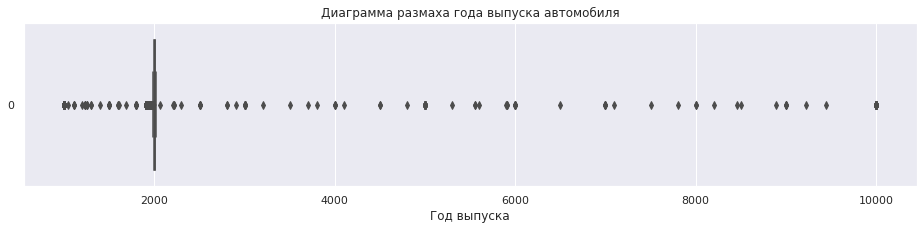

In [10]:
sns.set(style="darkgrid")
fig = plt.figure(figsize=(16,3))
ax = sns.boxplot(data=df['registrationyear'], orient='h')
ax.set_xlabel('Год выпуска')
plt.title("Диаграмма размаха года выпуска автомобиля")
plt.show()

Ограничим датасет по годам выпуска автомобиля с 1900 по текущий 2020 год.

In [11]:
df = df.query('1900 < registrationyear < 2020')

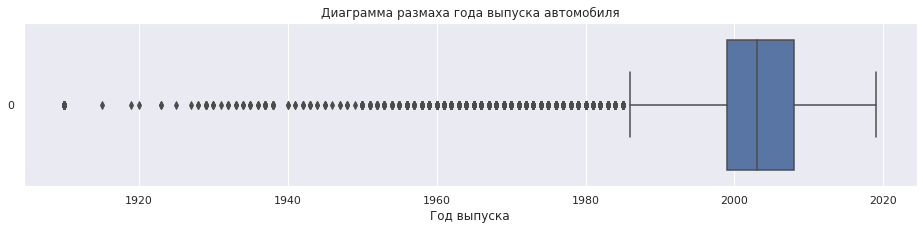

In [12]:
fig = plt.figure(figsize=(16,3))
ax = sns.boxplot(data=df['registrationyear'], orient='h')
ax.set_xlabel('Год выпуска')
plt.title("Диаграмма размаха года выпуска автомобиля")
plt.show()

Заменили артефакты раритетами.

Изучим столбец **power**

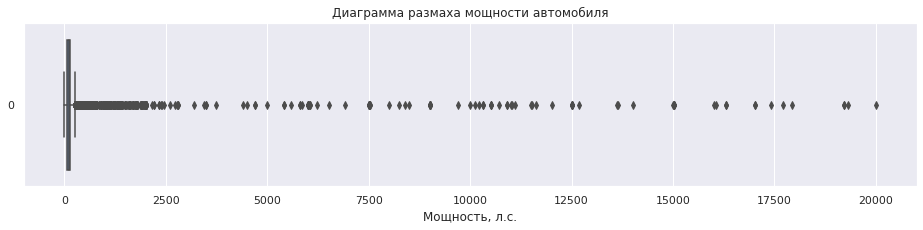

In [13]:
fig = plt.figure(figsize=(16,3))
ax = sns.boxplot(data=df['power'], orient='h')
ax.set_xlabel('Мощность, л.с.')
plt.title("Диаграмма размаха мощности автомобиля")
plt.show()

Ограничим максимальную мощность по правилу трёх сигм. 

In [14]:
adv_mean = df['power'].mean()
adv_var = variance = np.var(df['power'])
adv_std = np.sqrt(adv_var)
power_max = adv_mean + 3*adv_std
print('Ограничение максимальной мощности равно', power_max)

Ограничение максимальной мощности равно 678.6899849232713


В целом, серийных автомобилей мощнее 2 тыс.л.с. не производится, а машин с мощностью выше 1 тыс.л.с. единицы. Примем рассчитанное значение.

In [15]:
df = df.query('power < @power_max')

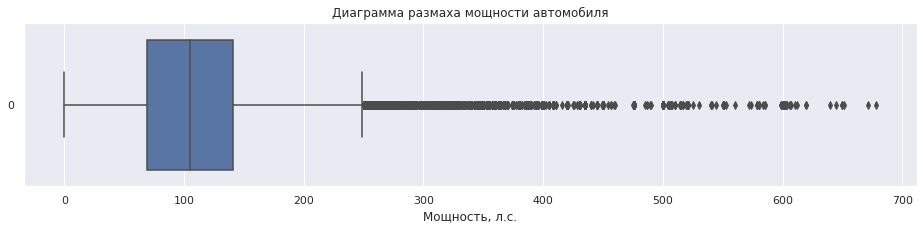

In [16]:
fig = plt.figure(figsize=(16,3))
ax = sns.boxplot(data=df['power'], orient='h')
ax.set_xlabel('Мощность, л.с.')
plt.title("Диаграмма размаха мощности автомобиля")
plt.show()

Посмотрим на самые мощные автомобили

In [17]:
review(df.query('power > 300'), 3)

datecrawled  price  vehicletype  registrationyear  \
head 41      2016-03-30 20:38:20   7500        sedan              2002   
     172     2016-03-07 12:38:19  19750  convertible              2006   
     204     2016-03-31 12:58:26  18400        wagon              2011   
tail 354063  2016-03-20 22:39:32  11500        wagon              2005   
     354092  2016-03-16 13:50:12  15550        sedan              2006   
     354333  2016-03-26 14:38:18  11500        sedan              2004   

            gearbox  power     model  kilometer  registrationmonth  fueltype  \
head 41        auto    306  e_klasse     150000                  4       NaN   
     172     manual    305   mustang      50000                  7    petrol   
     204       auto    313       5er     150000                 11  gasoline   
tail 354063    auto    340      300c     150000                  4    petrol   
     354092    auto    334        a6      90000                  1    petrol   
     354333    auto    445       7er     125000                  0    petrol   

                     brand notrepaired          datecreated  numberofpictures  \
head 41      mercedes_benz         NaN  2016-03-30 00:00:00                 0   
     172              ford          no  2016-03-07 00:00:00                 0   
     204               bmw          no  2016-03-31 00:00:00                 0   
tail 354063       chrysler          no  2016-03-20 00:00:00                 0   
     354092           audi         NaN  2016-03-16 00:00:00                 0   
     354333            bmw         NaN  2016-03-26 00:00:00                 0   

             postalcode             lastseen  
head 41           33649  2016-04-03 11:44:49  
     172          38350  2016-03-12 20:18:29  
     204          52477  2016-03-31 13:44:44  
tail 354063       25924  2016-04-01 11:44:42  
     354092       82152  2016-04-06 11:16:18  
     354333        4107  2016-04-06 20:45:16

Автомобили и правда хорошие, похоже на правду

Удалим столбец **numberofpictures** и **postalcode**

In [18]:
df.drop(['numberofpictures', 'postalcode'], axis='columns', inplace=True)

In [19]:
review(df, 4)

datecrawled  price  vehicletype  registrationyear  \
head 0       2016-03-24 11:52:17    480          NaN              1993   
     1       2016-03-24 10:58:45  18300        coupe              2011   
     2       2016-03-14 12:52:21   9800          suv              2004   
     3       2016-03-17 16:54:04   1500        small              2001   
tail 354361  2016-03-14 17:48:27   2200          NaN              2005   
     354362  2016-03-05 19:56:21   1199  convertible              2000   
     354363  2016-03-19 18:57:12   9200          bus              1996   
     354364  2016-03-20 19:41:08   3400        wagon              2002   

            gearbox  power        model  kilometer  registrationmonth  \
head 0       manual      0         golf     150000                  0   
     1       manual    190          NaN     125000                  5   
     2         auto    163        grand     125000                  8   
     3       manual     75         golf     150000                  6   
tail 354361     NaN      0          NaN      20000                  1   
     354362    auto    101       fortwo     125000                  3   
     354363  manual    102  transporter     150000                  3   
     354364  manual    100         golf     150000                  6   

             fueltype           brand notrepaired          datecreated  \
head 0         petrol      volkswagen         NaN  2016-03-24 00:00:00   
     1       gasoline            audi         yes  2016-03-24 00:00:00   
     2       gasoline            jeep         NaN  2016-03-14 00:00:00   
     3         petrol      volkswagen          no  2016-03-17 00:00:00   
tail 354361       NaN  sonstige_autos         NaN  2016-03-14 00:00:00   
     354362    petrol           smart          no  2016-03-05 00:00:00   
     354363  gasoline      volkswagen          no  2016-03-19 00:00:00   
     354364  gasoline      volkswagen         NaN  2016-03-20 00:00:00   

                        lastseen  
head 0       2016-04-07 03:16:57  
     1       2016-04-07 01:46:50  
     2       2016-04-05 12:47:46  
     3       2016-03-17 17:40:17  
tail 354361  2016-04-06 00:46:52  
     354362  2016-03-11 18:17:12  
     354363  2016-04-07 07:15:26  
     354364  2016-03-24 12:45:21

Приведем столбцы **datecrawled, datecreated, lastseen** к типу datetime64 и исследуем значения

In [20]:
df['datecrawled'] = pd.to_datetime(df['datecrawled'], format='%Y-%m-%d')
df['datecreated'] = pd.to_datetime(df['datecreated'], format='%Y-%m-%d')
df['lastseen'] = pd.to_datetime(df['lastseen'], format='%Y-%m-%d')

In [21]:
df_1 = pd.DataFrame(df["datecrawled"].describe())
df_2 = pd.DataFrame(df["datecreated"].describe())
df_3 = pd.DataFrame(df["lastseen"].describe())
display(explorer.show('df_1', 'df_2', 'df_3'))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  This is sepa

,datecrawled
count,353846
unique,270894
top,2016-03-24 14:49:47
freq,7
first,2016-03-05 14:06:22
last,2016-04-07 14:36:58
,datecreated
count,353846
unique,109
top,2016-04-03 00:00:00


Разброс дат крайне мал, вероятность их влияния на цены минимальна.Удалим данные столбцы.

In [22]:
df.drop(['datecrawled', 'datecreated', 'lastseen'], axis='columns', inplace=True)

Также рассмотрим корреляцию других столбцов

In [23]:
print(df.corr())

                      price  registrationyear     power  kilometer  \
price              1.000000          0.369056  0.485807  -0.334975   
registrationyear   0.369056          1.000000  0.113425  -0.170065   
power              0.485807          0.113425  1.000000   0.084247   
kilometer         -0.334975         -0.170065  0.084247   1.000000   
registrationmonth  0.110393          0.049655  0.131019   0.007849   

                   registrationmonth  
price                       0.110393  
registrationyear            0.049655  
power                       0.131019  
kilometer                   0.007849  
registrationmonth           1.000000  


Зависимость цены от месяца регистрации


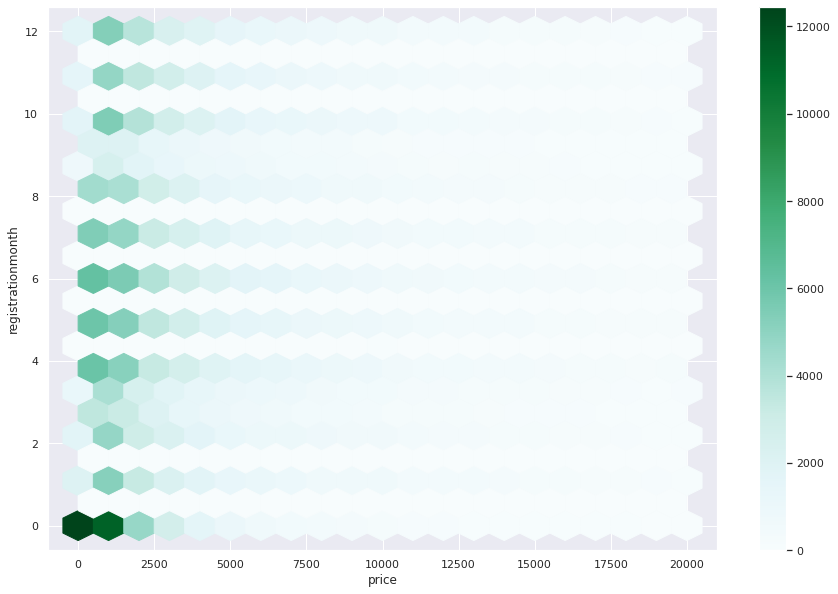

In [24]:
print('Зависимость цены от месяца регистрации')
explorer.hexbin(df, 'price', 'registrationmonth')

Зависимость цены от мощности


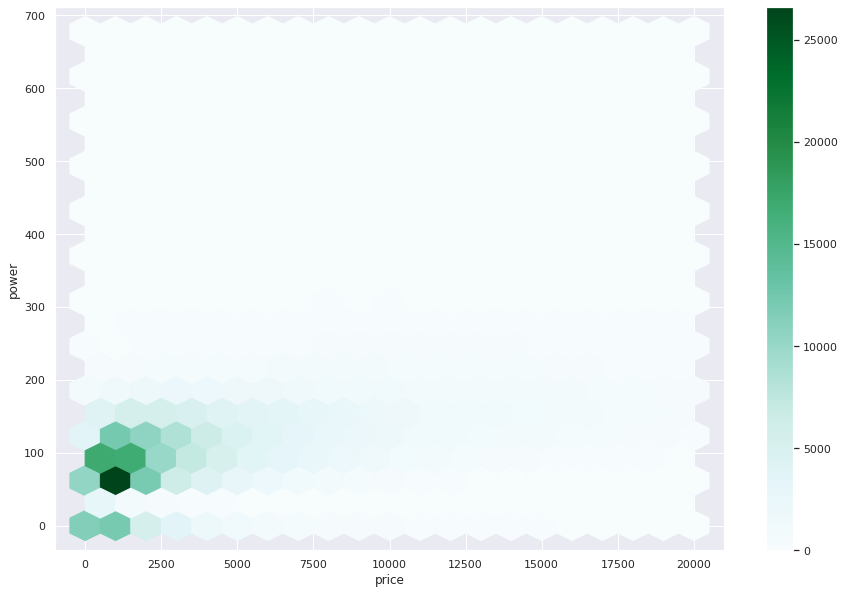

In [25]:
print('Зависимость цены от мощности')
explorer.hexbin(df, 'price', 'power')

Столбец **registrationmonth** имеет очень низкую, похожую на случайную корреляцию. Удалим столбец для ускорения производительности и для повышения качества модели.

In [26]:
df.drop(['registrationmonth'], axis='columns', inplace=True)

In [27]:
df = df.reset_index(drop=True)

In [28]:
review(df, 4)

price  vehicletype  registrationyear gearbox  power        model  \
head 0         480          NaN              1993  manual      0         golf   
     1       18300        coupe              2011  manual    190          NaN   
     2        9800          suv              2004    auto    163        grand   
     3        1500        small              2001  manual     75         golf   
tail 353842   2200          NaN              2005     NaN      0          NaN   
     353843   1199  convertible              2000    auto    101       fortwo   
     353844   9200          bus              1996  manual    102  transporter   
     353845   3400        wagon              2002  manual    100         golf   

             kilometer  fueltype           brand notrepaired  
head 0          150000    petrol      volkswagen         NaN  
     1          125000  gasoline            audi         yes  
     2          125000  gasoline            jeep         NaN  
     3          150000    petrol      volkswagen          no  
tail 353842      20000       NaN  sonstige_autos         NaN  
     353843     125000    petrol           smart          no  
     353844     150000  gasoline      volkswagen          no  
     353845     150000  gasoline      volkswagen         NaN

Исследуем общее количество пропусков и их процентное соотношение

In [29]:
display(explorer.show('pd.DataFrame(df.isnull().sum())', 'pd.DataFrame(df.isnull().sum() / len(df))'))

,0
price,0
vehicletype,37270
registrationyear,0
gearbox,19677
power,0
model,19585
kilometer,0
fueltype,32696
brand,0
notrepaired,70885


Количество пропусков в некоторых стобцах достигает 20%. Заполним их модами.

In [30]:
df_fill = df.copy()

Проверочный датасет для **vehicletype**

In [31]:
check_data = df_fill[pd.isnull(df_fill['vehicletype'])].head(10)
check_data

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
16,300,NaN,2016,NaN,60,polo,150000,petrol,volkswagen,NaN
22,2900,NaN,2018,manual,90,meriva,150000,petrol,opel,no
26,5555,NaN,2017,manual,125,c4,125000,NaN,citroen,no
31,899,NaN,2016,manual,60,clio,150000,petrol,renault,NaN
35,350,NaN,2016,manual,75,golf,150000,petrol,volkswagen,no
37,1500,NaN,2016,NaN,0,kangoo,150000,gasoline,renault,no
40,0,NaN,1990,NaN,0,corsa,150000,petrol,opel,NaN
48,7750,NaN,2017,manual,80,golf,100000,petrol,volkswagen,NaN
51,2000,NaN,2017,manual,90,punto,150000,gasoline,fiat,yes


Заполним **vehicletype** по названию модели и бренда

In [32]:
dict_for_type = df_fill.groupby(['model', 'brand'])['vehicletype'].apply(lambda x: x.mode()).to_dict()

dict_for_type = {(key[:-1]): value for key, value in dict_for_type.items()}

def filler(row):
    if type(row['vehicletype']) != str:
        return dict_for_type.get((row['model'], row['brand']), "unknown")
    return row['vehicletype']

df_fill['vehicletype'] = df_fill.apply(filler, axis=1)

Проверка

In [33]:
df_fill.query('index in @check_data.index')

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,NaN
16,300,small,2016,NaN,60,polo,150000,petrol,volkswagen,NaN
22,2900,bus,2018,manual,90,meriva,150000,petrol,opel,no
26,5555,sedan,2017,manual,125,c4,125000,NaN,citroen,no
31,899,small,2016,manual,60,clio,150000,petrol,renault,NaN
35,350,sedan,2016,manual,75,golf,150000,petrol,volkswagen,no
37,1500,bus,2016,NaN,0,kangoo,150000,gasoline,renault,no
40,0,small,1990,NaN,0,corsa,150000,petrol,opel,NaN
48,7750,sedan,2017,manual,80,golf,100000,petrol,volkswagen,NaN
51,2000,small,2017,manual,90,punto,150000,gasoline,fiat,yes


In [34]:
df_fill['vehicletype'].isna().sum()

0

Заполнено корректно

Проверочный датасет для **model**

In [35]:
check_data = df_fill[pd.isnull(df_fill['model'])].head(10)
check_data

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
59,1,suv,1994,manual,286,NaN,150000,NaN,sonstige_autos,NaN
81,350,small,1997,manual,54,NaN,150000,NaN,fiat,yes
115,0,small,1999,NaN,0,NaN,5000,petrol,volkswagen,NaN
135,1450,sedan,1992,manual,136,NaN,150000,NaN,audi,no
151,6799,small,2009,NaN,60,NaN,20000,petrol,volkswagen,no
160,500,small,1999,manual,0,NaN,150000,petrol,renault,no
161,1495,wagon,2001,NaN,64,NaN,150000,gasoline,volkswagen,NaN
186,14000,sedan,2008,NaN,235,NaN,150000,NaN,bmw,no
193,1200,coupe,1990,manual,45,NaN,150000,petrol,volkswagen,NaN


Заполним **model** по названию бренду, типу автомобиля и году регистрации

In [36]:
dict_for_type = df_fill.groupby(['vehicletype', 'brand', 'registrationyear'])['model'].apply(lambda x: x.mode()).to_dict()

dict_for_type = {(key[:-1]): value for key, value in dict_for_type.items()}

def filler(row):
    if type(row['model']) != str:
        return dict_for_type.get((row['vehicletype'], row['brand'], row['registrationyear']), "unknown")
    return row['model']

df_fill['model'] = df_fill.apply(filler, axis=1)

Проверка

In [37]:
df_fill.query('index in @check_data.index')

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
1,18300,coupe,2011,manual,190,a5,125000,gasoline,audi,yes
59,1,suv,1994,manual,286,unknown,150000,NaN,sonstige_autos,NaN
81,350,small,1997,manual,54,punto,150000,NaN,fiat,yes
115,0,small,1999,NaN,0,polo,5000,petrol,volkswagen,NaN
135,1450,sedan,1992,manual,136,80,150000,NaN,audi,no
151,6799,small,2009,NaN,60,polo,20000,petrol,volkswagen,no
160,500,small,1999,manual,0,twingo,150000,petrol,renault,no
161,1495,wagon,2001,NaN,64,passat,150000,gasoline,volkswagen,NaN
186,14000,sedan,2008,NaN,235,1er,150000,NaN,bmw,no
193,1200,coupe,1990,manual,45,polo,150000,petrol,volkswagen,NaN


In [38]:
df_fill['model'].isna().sum()

0

Заполнено корректно

По жизненному опыту известно, что значения столбцов **gearbox, fueltype, notrepaired** отражаются на цене автомобиля, но предсказания их значений по марке, бренду, мощности и году регистрации исказят результаты обучения. Пропуски в данных столбцах заполним как **unknown**.

In [39]:
df_fill.fillna('unknown', inplace=True)

Проверим результат

In [40]:
df_fill.isnull().sum()

price               0
vehicletype         0
registrationyear    0
gearbox             0
power               0
model               0
kilometer           0
fueltype            0
brand               0
notrepaired         0
dtype: int64

В столце **price** наблюдаются нулевые значения, скорее всего это непроданные машины или ошибка выгрузки данных. Удалим строки с нулевыми значениями, чтобы не портить модели обучения

In [41]:
before = len(df_fill)
df_fill = df_fill.query('price > 0')
after = len(df_fill)
print('Датасет до удаления имеет длину', before)
print('Датасет после удаления имеет длину', after)

Датасет до удаления имеет длину 353846
Датасет после удаления имеет длину 343127


Изучим датасет после предобработки

In [42]:
review(df_fill, 4)

price  vehicletype  registrationyear  gearbox  power  \
head 0         480        sedan              1993   manual      0   
     1       18300        coupe              2011   manual    190   
     2        9800          suv              2004     auto    163   
     3        1500        small              2001   manual     75   
tail 353842   2200      unknown              2005  unknown      0   
     353843   1199  convertible              2000     auto    101   
     353844   9200          bus              1996   manual    102   
     353845   3400        wagon              2002   manual    100   

                   model  kilometer  fueltype           brand notrepaired  
head 0              golf     150000    petrol      volkswagen     unknown  
     1                a5     125000  gasoline            audi         yes  
     2             grand     125000  gasoline            jeep     unknown  
     3              golf     150000    petrol      volkswagen          no  
tail 353842      unknown      20000   unknown  sonstige_autos     unknown  
     353843       fortwo     125000    petrol           smart          no  
     353844  transporter     150000  gasoline      volkswagen          no  
     353845         golf     150000  gasoline      volkswagen     unknown

In [43]:
df_fill.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343127 entries, 0 to 353845
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             343127 non-null  int64 
 1   vehicletype       343127 non-null  object
 2   registrationyear  343127 non-null  int64 
 3   gearbox           343127 non-null  object
 4   power             343127 non-null  int64 
 5   model             343127 non-null  object
 6   kilometer         343127 non-null  int64 
 7   fueltype          343127 non-null  object
 8   brand             343127 non-null  object
 9   notrepaired       343127 non-null  object
dtypes: int64(4), object(6)
memory usage: 28.8+ MB


Данные предобработаны и готовы к обучению модели

[Содержание](#title)

# 2. Обучение моделей  <a name="2"></a>

Обучать модели будем на основе градиентного бустинга. Прямую работу с категориальными параметрами обеспечивают библиотеки **CatBoost** и **LightGBM**. Для оценки времени обучения и скорости предсказания используем команду ```%%time```

Создадим выборки

In [44]:
target = df_fill['price']
features = df_fill.drop('price', axis=1)

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=RNG)
print(f'Размеры обучающих выборок {features_train.shape} и {target_train.shape}')
print(f'Размеры валидационных выборок {features_test.shape} и {target_test.shape}')

Размеры обучающих выборок (257345, 9) и (257345,)
Размеры валидационных выборок (85782, 9) и (85782,)


Выведем распределение признаков и оценку качества константных моделей для определения качества результатов моделей

In [45]:
target.describe()

count    343127.000000
mean       4557.105696
std        4515.718852
min           1.000000
25%        1200.000000
50%        2890.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

In [46]:
constant_mean = pd.Series(target_test.mean(), target_test.index)

rmse_mean = (mean_squared_error(target_test, constant_mean))**0.5

print('Константная средняя модель выдаёт RMSE =',rmse_mean)

Константная средняя модель выдаёт RMSE = 4521.128158952899


[Содержание](#title)

Зададим категориальные признаки

In [47]:
warnings.filterwarnings('ignore')

cat_features=cat_features = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']
for c in cat_features:
    features_train[c] = features_train[c].astype('category')
    
for c in cat_features:
    features_test[c] = features_test[c].astype('category')

### 2.1 Обучение CatBoost<a name="2.1"></a>

**model_cat_4**

In [48]:
%%time
model_cat_4 = CatBoostRegressor(random_state=RNG, iterations=300, depth=10, learning_rate=0.3, l2_leaf_reg=4,\
                                loss_function='RMSE', thread_count=3, early_stopping_rounds=5)
model_cat_4.fit(features_train, target_train, cat_features=cat_features, verbose=30)

0:	learn: 3609.3825507	total: 1.29s	remaining: 6m 25s
30:	learn: 1705.2943885	total: 41.6s	remaining: 6m 1s
60:	learn: 1614.8939322	total: 1m 25s	remaining: 5m 33s
90:	learn: 1561.1086085	total: 2m 5s	remaining: 4m 48s
120:	learn: 1530.9484097	total: 2m 45s	remaining: 4m 5s
150:	learn: 1503.1576471	total: 3m 30s	remaining: 3m 27s
180:	learn: 1476.3238717	total: 4m 15s	remaining: 2m 48s
210:	learn: 1459.3421061	total: 4m 58s	remaining: 2m 5s
240:	learn: 1441.5688542	total: 5m 42s	remaining: 1m 23s
270:	learn: 1425.3764584	total: 6m 26s	remaining: 41.4s
299:	learn: 1410.7946332	total: 7m 10s	remaining: 0us
CPU times: user 7min 1s, sys: 10.4 s, total: 7min 12s
Wall time: 7min 14s


In [49]:
%%time
print('Время предсказания:')
predicted_test_4 = model_cat_4.predict(features_test)

Время предсказания:
CPU times: user 1.11 s, sys: 44.3 ms, total: 1.16 s
Wall time: 1.1 s


Исследуем результат методом кросс-валидации

In [50]:
pool = Pool(data=features_train, label=target_train, cat_features=cat_features)

params = {}
params['iterations'] = 300
params['learning_rate'] = 0.3
params['depth'] = 10
params['loss_function'] = 'RMSE'
params['l2_leaf_reg'] = 4
params['thread_count'] = 3
params['random_state'] = RNG

In [51]:
%time
cv = cv(pool=pool,
        params=params,
        fold_count=3,
        shuffle=True,
        partition_random_seed=0,
        verbose=30,
        early_stopping_rounds=5)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs
0:	learn: 4825.5638754	test: 4826.0116013	best: 4826.0116013 (0)	total: 3.44s	remaining: 17m 9s
30:	learn: 1709.2410139	test: 1762.6727365	best: 1762.6727365 (30)	total: 1m 34s	remaining: 13m 36s
60:	learn: 1610.1675311	test: 1705.3814020	best: 1705.3814020 (60)	total: 3m 11s	remaining: 12m 29s
90:	learn: 1551.3040396	test: 1680.8695790	best: 1680.8695790 (90)	total: 4m 54s	remaining: 11m 15s
120:	learn: 1511.4893614	test: 1670.1624341	best: 1670.1624341 (120)	total: 6m 38s	remaining: 9m 50s
150:	learn: 1479.6137591	test: 1660.9106374	best: 1660.9106374 (150)	total: 8m 13s	remaining: 8m 7s
180:	learn: 1450.9396349	test: 1654.4540647	best: 1654.4540647 (180)	total: 9m 52s	remaining: 6m 29s
210:	learn: 1427.1133049	test: 1650.2024365	best: 1650.2024365 (210)	total: 11m 28s	remaining: 4m 50s
Stopped by overfitting detector  (5 iterations wait)


Полученная модель обладает приемлемой точностью, долгим временем обучения и быстрым предсказанием результатов.

[Содержание](#title)

### 2.2 Обучение LightGBM <a name="2.2"></a>

**model_lgbm_3**

In [52]:
%%time
model_lgbm_3 = lgb.LGBMRegressor(random_state=RNG, max_depth = 10, learning_rate=0.2)
model_lgbm_3.fit(features_train, target_train)

CPU times: user 7.62 s, sys: 19.1 ms, total: 7.63 s
Wall time: 7.67 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.2, max_depth=10,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [53]:
%%time
print('Время предсказания:')
predicted_lgbm_3 = model_lgbm_3.predict(features_test)

Время предсказания:
CPU times: user 916 ms, sys: 0 ns, total: 916 ms
Wall time: 905 ms


Исследуем результат методом кросс-валидации

In [54]:
def rmse(target, pred):
    return (mean_squared_error(target, pred))**0.5

custom_scorer = make_scorer(rmse, greater_is_better=False)

In [55]:
%%time
print('RMSE =', np.abs(cross_val_score(model_lgbm_3, features_train, target_train, cv=3, scoring=custom_scorer)).mean())

RMSE = 1669.462744465065
CPU times: user 19.9 s, sys: 129 ms, total: 20 s
Wall time: 20.3 s


Полученная модель обладает приемлемой точностью, низким временем обучения и быстрым предсказанием результатов.

[Содержание](#title)

### 2.3 Обучение логистической регрессии <a name="2.3"></a>

Преобразуем категориальные признаки в численные при помощи техники прямого кодирования, или отображения (**One-Hot Encoding, OHE**), предусмотрев наличие дамми ловушек (dummy trap).

In [56]:
df_hot = pd.get_dummies(df_fill, drop_first=True)

target_hot = df_hot['price']
features_hot = df_hot.drop('price', axis=1)

features_train_hot, features_test_hot, target_train_hot, target_test_hot = train_test_split(features_hot, target_hot, test_size=0.25, random_state=RNG)
print(f'Размеры обучающих выборок {features_train_hot.shape} и {target_train_hot.shape}')
print(f'Размеры валидационных выборок {features_test_hot.shape} и {target_test_hot.shape}')

Размеры обучающих выборок (257345, 311) и (257345,)
Размеры валидационных выборок (85782, 311) и (85782,)


Обучим модель

In [57]:
%time
model_logistic = LinearRegression()
model_logistic.fit(features_train_hot, target_train)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [58]:
%%time
print('Время предсказания:')
model_logistic_predict = model_logistic.predict(features_test_hot)

Время предсказания:
CPU times: user 137 ms, sys: 126 ms, total: 264 ms
Wall time: 221 ms


In [59]:
%%time
print('RMSE =', np.abs(cross_val_score(model_logistic, pd.get_dummies(features_train, drop_first=True), target_train, cv=3, scoring=custom_scorer)).mean())

RMSE = 2777.790689509801
CPU times: user 43.7 s, sys: 11.9 s, total: 55.6 s
Wall time: 56 s


Полученная модель обладает низкой точность (по сравнению с моделями градиентного бустинга), быстрое время обучения и предсказания, но требует предварительной обработки категориальных признаков.

[Содержание](#title)

# 3. Анализ моделей <a name="3"></a>

Все обученные модели показали качество выше констаных моделей

Сравним лучшие модели для обеих библиотек

In [62]:
data = {'Библиотека': ['CatBoostRegressor', 'LGBMRegressor', 'LinearRegression'],\
        'Модель': ['model_cat_4', 'model_lgbm_3', 'model_logistic'],\
        'rmse, на кросс-валидации': ['1650.20', '1669.46', '2777.79'],\
        'Время обучения, секунд': ['434', '7.67', '0.000008'],\
        'Время предсказания, секунд': ['1.1', '0.000905', '0.000211']}
research = pd.DataFrame(data=data)

research.style.highlight_min(['rmse, на кросс-валидации', 'Время обучения, секунд', 'Время предсказания, секунд'],color='lightgreen', axis = 0)

,Библиотека,Модель,"rmse, на кросс-валидации","Время обучения, секунд","Время предсказания, секунд"
0,CatBoostRegressor,model_cat_4,1650.20,434,1.1
1,LGBMRegressor,model_lgbm_3,1669.46,7.67,0.000905
2,LinearRegression,model_logistic,2777.79,0.000008,0.000211


Модели градиентного бустинга показывают намного большую точность, чем модель логистической регрессии, поэтому использовать её не рекомендуется.

По двум параметрам из трех лучшей оказалась модель **model_lgbm_3** из библиотеки **LGBMRegressor**. Модель показала высокую точность, низкое время обучения и предсказания. Модель **model_cat_4** оказалась сложнее для из-за большого количества итераций в обучении.

Само по себе время обучения и предсказания очень приблизительно, т.к. зависит от скорости выполнения на определенном компьютере в данный момент времени.

Для решения конкретной задачи выберем **model_lgbm_3**. Посмотрим значение метрики **RMSE** на тестовых данных

In [64]:
print('RMSE =', (mean_squared_error(target_test, predicted_lgbm_3))**0.5)

RMSE = 1656.8801296223046


Модель адекватна. Точность модели могла пострадать на этапе предобработки данных, т.к. заполнение пропусков могло усложнить модель и добавить в перечень плохо описанные автомобили.

Модель **CatBoost** имеет лучшие показатели относительно других моделей при отсутствии настроек. В целом, выбор модели для каждого датасета очень индивидуален и должен подбираться под определенный набор данных. К преемуществам библиотеки также можно отнести отсутствие необходимости проведения допольнительной обработки категориальных признаков.

[Содержание](#title)